In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
data = pd.read_csv('ner_dataset.csv',encoding='latin1')
data.fillna(method='ffill',inplace=True) 
#use method 'ffill' to fill nan with the nearest value before nan
data['Sentence #'] = data['Sentence #'].apply(lambda x: int(x[10:]))
data.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [54]:
num_tags = data.Tag.nunique() #17 target values
words = list(set(data.Word))
words.append('ENDPAD') #For padding use
num_words = len(words)
num_tags,num_words

(17, 35179)

In [63]:
#create a class to retrieve sentences and tags, which are correspondingly inputs and outputs
#each sentence will be broken into a list of tuples, each tuple contains word, pos, tag
#so the output will be a list of lists of tuples
class SentenceGetter(object):
    def __init__(self,data):
        self.data = data
        self.gb = self.data.groupby('Sentence #').apply(
            lambda s: [(w,p,t) for (w,p,t) in zip(s.Word.values,s.POS.values,s.Tag.values)]) 
        #cannot use agg here, groupby.apply is applied on each group(here is sentence)
        #groupby.agg is applied on each column in the group
        self.sentences = [i for i in self.gb]

In [68]:
getter = SentenceGetter(data)
sentences = getter.sentences

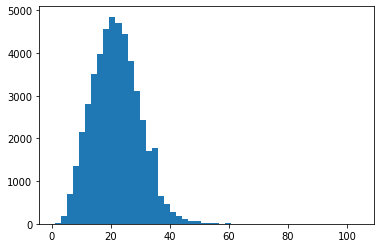

In [77]:
#to visualize the length of the sentences, use histogram, instead of bar chart
#histogram is to plot the distribution
gb = data.groupby('Sentence #').apply(len)
plt.hist([l for l in gb],bins=50)
plt.show()
#after observing the distribution of length of sentences, choose max_len = 50
max_len = 50

In [85]:
#prepare inputs(X) and outputs(y), before splitting into train and test sets
#integer encode X and y, pad X and y, and then one hot encode y
#create dictionaries to map words to idx, tags to idx 
word2idx = {w:i for i,w in enumerate(words)}
tags = list(set(data.Tag.values))
tag2idx = {t:i for i,t in enumerate(tags)}

X = [[word2idx[w[0]] for w in s] for s in sentences] 
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(sequences=X,padding='post',value=num_words-1,maxlen=max_len)
#list comprehension containing two for loops[[..for..in] for..in..]
#create a list of integer encoded sentences, each sentence is a list inside the list
y = [[tag2idx[t[2]] for t in s] for s in sentences]
y = pad_sequences(sequences=y, maxlen=max_len, value=tag2idx['O'], padding='post')
#one hot encode y
#for classification problems, keras models only take one hot encoded multiclass labels as targets
from keras.utils import to_categorical
y = to_categorical(y,num_classes=num_tags).tolist()
#now split into train and test sets, as for validation set, define when using model.fit()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [89]:
from keras import Model, Input
from keras.layers import LSTM, Dense, Embedding, Bidirectional, TimeDistributed, SpatialDropout1D

In [91]:
'''for the embedding layer: 
* input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
* output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
* input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.
'''
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [101]:
from keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

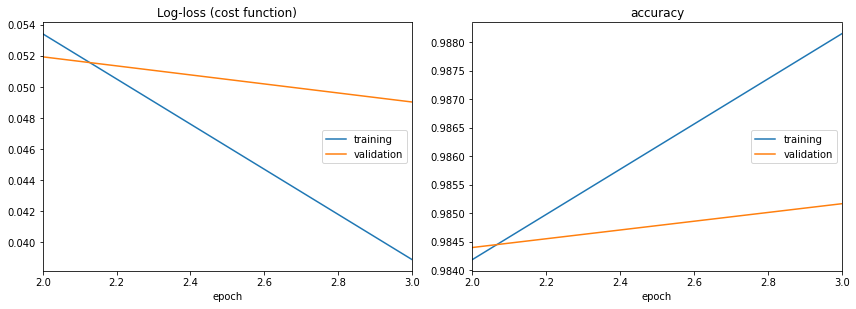

Log-loss (cost function):
training   (min:    0.039, max:    0.190, cur:    0.039)
validation (min:    0.049, max:    0.070, cur:    0.049)

accuracy:
training   (min:    0.957, max:    0.988, cur:    0.988)
validation (min:    0.980, max:    0.985, cur:    0.985)


In [103]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=1,
                              verbose=1,
                              mode='max')
callbacks = [PlotLossesCallback(),early_stopping]
history = model.fit(X_train,np.array(y_train),  #X and y have to be np.array, here y_train is a list
                   validation_split=0.2,
                   batch_size=32,
                   epochs=3,
                   verbose=1,
                   callbacks=callbacks)

In [105]:
model.evaluate(X_test,np.array(y_test))

4796/4796 [==============================] - 2s 435us/step


[0.04873385313926288, 0.9850167036056519]

In [171]:
i = np.random.randint(0,X_test.shape[0])
pred_idx = np.argmax(model.predict(X_test)[i],axis=1)
preds = [tags[t] for t in pred_idx]
true_idx = np.argmax(np.array(y_test[i]),axis=1)
true_labels = [tags[t] for t in true_idx]
w = [words[j] for j in X_test[i]]
print('{:12} {:15}\t {:15}\n'.format('words','true labels','predictions'))
print('-'*45)
for w, true_label, pred in zip(w,true_labels,preds):
    print('{:12} {:15}\t {:15}\n'.format(w,true_label,pred))

words        true labels    	 predictions    

---------------------------------------------
U.S.         B-org          	 B-org          

Energy       I-org          	 I-org          

Secretary    O              	 O              

Samuel       B-per          	 I-per          

Bodman       I-per          	 I-per          

told         O              	 O              

television   O              	 O              

interviewers O              	 O              

the          O              	 O              

oil          O              	 O              

will         O              	 O              

be           O              	 O              

loaned       O              	 O              

to           O              	 O              

refiners     O              	 O              

who          O              	 O              

need         O              	 O              

it           O              	 O              

.            O              	 O              

ENDPAD       O